In [2]:
import torch as t 
import torchvision
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import random

In [3]:
device = 'cuda' # cuda or cpu

In [73]:
batch_size = 64
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 0.1 # априорная дисперсия
epoch_num = 50 #количество эпох
lamb = [0, 0.1, 0.5, 1, 5, 10, 100, 1000]
# lam = 1.0 # коэффициент перед дивергенцией
hidden_num = 100 # количество нейронов на скрытом слое
t.manual_seed(42) # задаем значение генератора случайных чисел для повторяемости экспериментов
acc_delete = [] 
filename = 'Hypernet_linear_lamn1_sn3+1' # куда сохранять
lam_hidden_num = 1
start_num = 3
mode = 'linear'
lambda_sample_num = 5

In [74]:
# сохранение данных
def save(file):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()
    
def load(path = filename):
    infile = open(path, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file
    
    

In [75]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)


In [76]:
class LowRankNet(nn.Module):
    def __init__(self, size, hidden, gain_const = 1.0, gain_lamb = 1.0,
                 gain_lowrank = .0001,  act= F.relu):    
        nn.Module.__init__(self)        
        self.w = nn.Linear(1, hidden).to(device)
        t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
        # проверка на вектор или матрица
        if isinstance(size, tuple) and len(size) == 2: # если сайз неизменяемый список и его длина 2
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1,device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            self.w_d = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform(self.w_d.weight, gain_lowrank)
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            
        else:
            self.w_a1 = nn.Linear(hidden, self.in_).to(device)
            t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
            
            self.w_a2 = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
            
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const,  gain_const)
            
            
    def forward(self, lam):
        h = self.act(self.w(self.one * lam))        
        if self.diagonal:
            return self.const + self.w_d(h)
        else:
            a1 = self.w_a1(h)
            a2 = self.w_a2(h)
         
            return self.const +  t.matmul(a1.view(-1, 1), a2.view(1, -1))

        
class LinearApprNet(nn.Module):
    def __init__(self, size,  gain_const = 1.0, gain_const2 = 0.000001,  act= lambda x: x):    
        nn.Module.__init__(self)        
        if isinstance(size, tuple) and len(size) == 2:
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1, device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            self.const2 = nn.Parameter(t.ones(self.out_, device=device) * gain_const2) 
            
            
        else:
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const,  gain_const)
            self.const2 = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const2,  gain_const2)
            
            
    def forward(self, lam):        
        if self.diagonal:
            return self.const + self.const2 * lam
        else:
            return self.const + self.const2 * lam 
                

In [77]:
# проверка что все работает
# случай вектора
n = LowRankNet(100, 10)
n(100)- n(0)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


tensor([ 1.1579e-03,  4.4358e-04, -3.1865e-04,  3.2437e-04,  9.0420e-05,
         3.2893e-04,  4.0364e-04,  8.0103e-04,  3.8385e-04, -1.4532e-04,
         9.3460e-05, -8.5342e-04, -4.9203e-04,  1.0955e-03,  2.6686e-04,
        -5.0107e-04, -6.9356e-04, -3.5524e-05,  1.4722e-04, -4.9192e-04,
         1.3196e-04,  7.8094e-04, -5.0154e-04,  3.7491e-04, -7.2670e-04,
        -4.2802e-04, -2.1482e-04, -6.1572e-05,  7.6455e-04, -8.5819e-04,
        -5.1409e-04, -3.8001e-04, -2.3258e-04, -5.6469e-04, -4.0627e-04,
        -3.2903e-04,  1.0856e-03, -8.3484e-04, -9.5175e-04,  6.8972e-04,
         1.2767e-04, -1.1337e-03,  3.4571e-04,  6.0070e-04,  5.2279e-04,
        -3.9132e-04, -1.2994e-04, -1.7625e-04,  7.2122e-06, -2.2772e-04,
        -2.9835e-04, -1.7881e-07,  6.0558e-04,  4.9710e-05,  6.5863e-04,
         7.4020e-04,  2.1636e-04,  2.3735e-04,  4.2582e-04,  1.0834e-03,
        -4.0892e-04, -7.6619e-04, -2.2078e-04,  4.9284e-04, -5.7805e-04,
         9.3067e-04,  1.1504e-04,  5.8293e-04, -4.3

In [78]:
# проверка что все работает
# случай матрицы
n = LowRankNet((100, 20), 10)
n(100) - n(0)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


tensor([[-6.1625e-04,  4.0583e-04, -6.5077e-05,  ...,  3.8743e-07,
          3.6196e-04,  3.4638e-04],
        [ 6.1025e-04, -4.2704e-04, -5.9105e-05,  ..., -2.4839e-04,
         -5.2603e-04, -4.3452e-05],
        [-5.3713e-04,  3.5816e-04, -3.5007e-05,  ...,  4.3936e-05,
          3.4495e-04,  2.4928e-04],
        ...,
        [-6.3423e-04,  4.0828e-04, -1.1307e-04,  ..., -9.2089e-05,
          3.1003e-04,  4.6821e-04],
        [ 6.0985e-04, -4.0704e-04,  3.7774e-05,  ..., -5.3838e-05,
         -3.9433e-04, -2.7824e-04],
        [ 8.3520e-04, -5.5788e-04,  4.9610e-05,  ..., -7.7993e-05,
         -5.4292e-04, -3.7590e-04]], device='cuda:0', grad_fn=<SubBackward0>)

In [79]:
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_, device=device)) # параметры средних
        t.nn.init.xavier_uniform(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_, device = device)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_, device=device)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_, device=device) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  t.exp(self.log_sigma_b))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    
class VarLayerLowRank(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LowRankNet((in_, out_), lam_hidden_num) # параметры средних            
        self.log_sigma = LowRankNet((in_, out_), lam_hidden_num) # логарифм дисперсии
        self.mean_b = LowRankNet( out_, lam_hidden_num) # то же самое для свободного коэффициента
        self.log_sigma_b = LowRankNet( out_, lam_hidden_num)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    

class VarLayerLinearAppr(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LinearApprNet((in_, out_)) # параметры средних            
        self.log_sigma = LinearApprNet((in_, out_)) # логарифм дисперсии
        self.mean_b = LinearApprNet( out_) # то же самое для свободного коэффициента
        self.log_sigma_b = LinearApprNet( out_)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self, x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2    

In [80]:
l = VarLayerLinearAppr(784, 10)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [81]:
l.log_sigma_b(100)

tensor([-2.9999, -2.9999, -2.9999, -2.9999, -2.9999, -2.9999, -2.9999, -2.9999,
        -2.9999, -2.9999], device='cuda:0', grad_fn=<AddBackward0>)

In [82]:
class VarSeqNet(nn.Sequential):    
    # класс-обертка на случай, если у нас многослойная нейронная сеть
    def KLD(self, lam = None):
        k = 0
        for l in self: 
            if lam is None:
                k+=l.KLD()
            else:
                k+=l.KLD(lam)
                
        return k
    
    def forward(self, x, lam = None):
        if lam is None:
            for l in self:
                x = l(x)
            return x
        else:
            for l in self:
                x = l(x, lam)
            return x
    


In [83]:
def train_batches(net, loss_fn, optimizer, i, out, out_loss, kld, loss, epoch, lam):
    for id, (x,y) in enumerate(train_loader):  
            id+=1
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()            
            optimizer.zero_grad() 
            loss[i] = 0 
            for _ in range(lambda_sample_num):
                if (mode == 'frank'):
                    lam_param = None
                else:
                    lam = np.random.uniform(0, 100)
                    lam_param = lam/100
                out[i] = net(x, lam_param)
                # правдоподобие должно суммироваться по всей обучающей выборке
                # в случае батчей - она приводится к тому же порядку 
                out_loss[i] = loss_fn(out[i], y)* len(train_data) 
                kld[i] =  net.KLD(lam_param) *lam
                loss[i] += (out_loss[i]+kld[i])       
            if id %100 == 0:           
                print ("Number of net:",i, loss[i].data, out_loss[i].data, kld[i].data, lam)            

            
            loss[i].backward()       
            clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
            optimizer.step()

In [84]:
def statistic(net, loss_fn, i, kld, loss, out, out_loss):
    net.eval()  
    kld[i] =  net.KLD(1) 
    loss[i] = kld[i]
    for x,y in test_loader:
         if device == 'cuda':
            x = x.cuda()
            y = y.cuda()          
    out[i] = net(x, 1)   
    out_loss[i] = loss_fn(out[i], y)* len(train_data)
    #  print(out_loss[i])
    # print(loss[i])
    loss[i] += out_loss[i]
    net.train()
    print (loss[i])
    return loss[i]


    

In [85]:
# рассмотрим для примера сеть, состояющую из двух слоев
# второй слой - softmax. По сути для обучения задавать активацию явно не нужно, она забита в nn.CrossEntropyLoss
def init_nets(loss_fn_nets):
    for i in range(start_num):
        if mode == 'lowrank':
            nets.append(VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x)))
        elif mode == 'linear':
            nets.append(VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x)))
        else:
            raise ValueError('Bad mode')
        optimizer_nets.append(optim.SGD(nets[i].parameters(), lr=0.001))
        loss_fn_nets.append(nn.CrossEntropyLoss())
    loss_graph=[[],[],[]]
    out = [None, None, None]
    out_loss = [None, None, None]
    kld = [None, None, None]
    loss = [None, None, None]
    return out, out_loss, kld, loss, loss_graph

def train_nets(out, out_loss, kld, loss, loss_graph,l_frank):
    for epoch in range(epoch_num):             
        for i,net in enumerate(nets):
            train_batches(net,loss_fn_nets[i], optimizer_nets[i],i, out, out_loss, kld, loss, epoch, l_frank)
        print ('end of epoch: ', epoch)   
        for i,net in enumerate(nets):
            print("Number of net:",i)        
            #loss_graph[i].append(statistic(net, loss_fn_nets[i], i, kld, loss, out, out_loss))

        

In [86]:
#print(loss_graf)
def graph_loss_func(loss_graph, nets):
    for i,net in enumerate(nets): 
        plt.plot(loss_graph[i])
    plt.ylabel('Loss function')
    plt.xlabel('Number of epoche')
    plt.show()
#print(out_loss)

#graph_loss_func()

In [87]:
def test_acc(out): # точность классификации
    acc = []
    for i,net in enumerate(nets):
        correct = 0
        net.eval()
        for x,y in test_loader:
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()     
            out[i] = net(x)    
            correct += out[i].argmax(1).eq(y).sum().cpu().numpy()
        acc.append(correct / len(test_data))
    print(sum(acc)/len(acc))   
    return(acc)
#test_acc(out)

In [88]:
# коэффициенты информативности, см. статью practical variational inference
# попробуем удалять параметры первого слоя по этому коэффициенту

def init_coeff(prune_coef, mu, sigma):
    for i,net in enumerate(nets): 
        mu.append(net[0].mean) 
        sigma.append(t.exp(2*net[0].log_sigma))
        prune_coef.append((mu[i]**2/sigma[i]).cpu().detach().numpy())  


In [89]:
# будем удалять по 10% от модели и смотреть качество
def delete_10(acc_delete, prune_coef, mu, sigma, nets, out):
    acc_delete = []
    sorted_coefs = []
    for i, net in enumerate(nets):
        sorted_coefs.append(np.sort(prune_coef[i].flatten()))
    for j in range(10):
        for i,net in enumerate(nets): 
            ids = (prune_coef[i] <= sorted_coefs[i][round(j/10*len(sorted_coefs[i]))]) 
            net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
            print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        acc_delete.append(test_acc(out))
    return acc_delete    


In [95]:
def graph(acc_delete, lamb):
    proc = [0,10,20,30,40,50,60,70,80,90]
    plt.rcParams['figure.figsize'] = 12, 12
    for k, lam in enumerate(lamb):
        acc_delete_n = np.array(acc_delete[k])
        plt.plot(proc, np.mean(acc_delete_n, 1), label = 'lambda = {}'.format(str(lam)))
        # откладываем ошибку вокруг среднего, альфа - прозрачность линии
        plt.fill_between(proc, np.mean(acc_delete_n, 1)  + np.std(acc_delete_n, 1) , np.mean(acc_delete_n, 1) - np.std(acc_delete_n, 1) , alpha = 0.5 )
    plt.ylabel('Точность классификации', fontsize = 20)
    plt.xlabel('Процент удаления', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(loc='best')
    plt.savefig('Linear_lamn1_sn3+1_train')
    plt.show()

#acc_delete = load('Hypernet_lowrank_lamn50_x')    
#graph(acc_delete, lamb)


    

In [91]:
# проверяем, что фокусов тут нет, удаляем оставшиеся 10%\
def delete_last10():
    flag = 0
    for j in range(10):
        for i,net in enumerate(nets): 
            if (flag == 0):
                sorted_coefs = np.sort(prune_coef[i].flatten())
                flag = 1
            ids = (prune_coef[i] <= sorted_coefs[round((0.9+j/100)*len(sorted_coefs))]) 
            net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
            print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        (test_acc())
    for i,net in enumerate(nets):
        net[0].mean.data*=0
        print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
    (test_acc())
    
#delete_last10()    

/usr/lib/python3/dist-packages/ipykernel_launcher.py:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Number of net: 0 tensor(6333831., device='cuda:0') tensor(47896.3828, device='cuda:0') tensor(1770441.6250, device='cuda:0') 73.79503993110629
Number of net: 0 tensor(3440874.2500, device='cuda:0') tensor(49321.4648, device='cuda:0') tensor(1136494., device='cuda:0') 78.02643433537668
Number of net: 0 tensor(3191459., device='cuda:0') tensor(66317.3125, device='cuda:0') tensor(629618.3125, device='cuda:0') 64.29674999121185
Number of net: 0 tensor(2006385.7500, device='cuda:0') tensor(62203.3164, device='cuda:0') tensor(310225.0625, device='cuda:0') 31.131612241440042
Number of net: 0 tensor(1110542.5000, device='cuda:0') tensor(54394.3125, device='cuda:0') tensor(46781.5273, device='cuda:0') 3.8735382657418715
Number of net: 0 tensor(1114447.1250, device='cuda:0') tensor(77186.2188, device='cuda:0') tensor(185023.5312, device='cuda:0') 62.4906132041185
Number of net: 0 tensor(1057604.3750, device='cuda:0') tensor(81155.7188, device='cuda:0') tensor(69401.4141, device='cuda:0') 7.91859

Number of net: 0 tensor(579389.7500, device='cuda:0') tensor(37252.7344, device='cuda:0') tensor(66746.2891, device='cuda:0') 21.498860698151812
Number of net: 0 tensor(841304.8750, device='cuda:0') tensor(77017.1484, device='cuda:0') tensor(74546.9922, device='cuda:0') 60.317246203186535
Number of net: 0 tensor(648568.1875, device='cuda:0') tensor(63561.6367, device='cuda:0') tensor(72921.1250, device='cuda:0') 45.111148229169785
Number of net: 0 tensor(549103.6250, device='cuda:0') tensor(71195.9688, device='cuda:0') tensor(29728.1133, device='cuda:0') 7.405447392140985
Number of net: 0 tensor(757579.3125, device='cuda:0') tensor(62575.0859, device='cuda:0') tensor(80506.4141, device='cuda:0') 69.02169834771307
Number of net: 0 tensor(734432.3750, device='cuda:0') tensor(68521.7734, device='cuda:0') tensor(106785.7812, device='cuda:0') 82.2859136961555
Number of net: 0 tensor(774523.8750, device='cuda:0') tensor(135917.4531, device='cuda:0') tensor(130894.2422, device='cuda:0') 90.47

Number of net: 0 tensor(847904.6875, device='cuda:0') tensor(83583.5703, device='cuda:0') tensor(97255.8516, device='cuda:0') 78.9703562306801
Number of net: 0 tensor(768236.3750, device='cuda:0') tensor(95865.2656, device='cuda:0') tensor(94485.1641, device='cuda:0') 79.02065144034701
Number of net: 0 tensor(1168605.2500, device='cuda:0') tensor(117021.9297, device='cuda:0') tensor(94237.8672, device='cuda:0') 79.84111172642645
Number of net: 0 tensor(646835.5000, device='cuda:0') tensor(52682.3711, device='cuda:0') tensor(68175.1562, device='cuda:0') 51.08263910480104
Number of net: 0 tensor(704681.1250, device='cuda:0') tensor(43558.0391, device='cuda:0') tensor(41777.1562, device='cuda:0') 19.79845423818144
Number of net: 1 tensor(529734.5000, device='cuda:0') tensor(34288.7148, device='cuda:0') tensor(63308.0273, device='cuda:0') 38.91490134336883
Number of net: 1 tensor(891828.6250, device='cuda:0') tensor(160535.8281, device='cuda:0') tensor(107948.8125, device='cuda:0') 86.8314

Number of net: 0 tensor(487053.8750, device='cuda:0') tensor(49606.3516, device='cuda:0') tensor(46283.6055, device='cuda:0') 26.210209184204956
Number of net: 0 tensor(616621.7500, device='cuda:0') tensor(73329.1641, device='cuda:0') tensor(45565.3789, device='cuda:0') 27.21978270284362
Number of net: 0 tensor(496148.2188, device='cuda:0') tensor(25531.0254, device='cuda:0') tensor(16182.6680, device='cuda:0') 7.031591894283606
Number of net: 1 tensor(591814.6875, device='cuda:0') tensor(34756.0391, device='cuda:0') tensor(21721.0859, device='cuda:0') 9.499132983818937
Number of net: 1 tensor(712811.6250, device='cuda:0') tensor(50906.1484, device='cuda:0') tensor(2941.7251, device='cuda:0') 1.171685513089027
Number of net: 1 tensor(865036.3750, device='cuda:0') tensor(149754.7344, device='cuda:0') tensor(135211.2188, device='cuda:0') 94.65680739534844
Number of net: 1 tensor(676575.7500, device='cuda:0') tensor(56811., device='cuda:0') tensor(23628.4629, device='cuda:0') 10.987902868

Number of net: 0 tensor(682963.8750, device='cuda:0') tensor(38640.9922, device='cuda:0') tensor(48114.0078, device='cuda:0') 29.733658475242343
Number of net: 1 tensor(749296.5625, device='cuda:0') tensor(146145.9062, device='cuda:0') tensor(110179.3125, device='cuda:0') 86.26005147716495
Number of net: 1 tensor(852502.5000, device='cuda:0') tensor(82208.9297, device='cuda:0') tensor(70037.2969, device='cuda:0') 59.24881164576414
Number of net: 1 tensor(1027971.6250, device='cuda:0') tensor(110178.8125, device='cuda:0') tensor(99454.4688, device='cuda:0') 81.5483517910142
Number of net: 1 tensor(560298., device='cuda:0') tensor(61557.1250, device='cuda:0') tensor(53025.2227, device='cuda:0') 38.677473904108716
Number of net: 1 tensor(727939.6250, device='cuda:0') tensor(49524.9141, device='cuda:0') tensor(33905.0703, device='cuda:0') 18.756899715970576
Number of net: 1 tensor(701772.6875, device='cuda:0') tensor(64128.6562, device='cuda:0') tensor(17342.7734, device='cuda:0') 8.184625

Number of net: 1 tensor(820032.5000, device='cuda:0') tensor(52111.9297, device='cuda:0') tensor(27171.9805, device='cuda:0') 14.80441069188264
Number of net: 1 tensor(635004.1250, device='cuda:0') tensor(68945.2188, device='cuda:0') tensor(98913.5156, device='cuda:0') 81.10761408839348
Number of net: 1 tensor(444231.3125, device='cuda:0') tensor(34272.5664, device='cuda:0') tensor(13678.7021, device='cuda:0') 6.622373212617538
Number of net: 1 tensor(786713.2500, device='cuda:0') tensor(42980.9961, device='cuda:0') tensor(42978.7109, device='cuda:0') 27.766379639114003
Number of net: 1 tensor(751886.6875, device='cuda:0') tensor(46236.9258, device='cuda:0') tensor(101126.7656, device='cuda:0') 82.74710869251774
Number of net: 1 tensor(780951.3750, device='cuda:0') tensor(54941.9062, device='cuda:0') tensor(65893.4219, device='cuda:0') 55.993703431634266
Number of net: 1 tensor(740472.7500, device='cuda:0') tensor(96431.7188, device='cuda:0') tensor(83159.0625, device='cuda:0') 71.3472

Number of net: 1 tensor(926849.7500, device='cuda:0') tensor(189146.9219, device='cuda:0') tensor(128340.0312, device='cuda:0') 93.1463561182838
Number of net: 1 tensor(815985., device='cuda:0') tensor(104553.6094, device='cuda:0') tensor(80289.5469, device='cuda:0') 67.75469730326947
Number of net: 1 tensor(489494.8125, device='cuda:0') tensor(41558.2500, device='cuda:0') tensor(42039.1758, device='cuda:0') 28.195737059497972
Number of net: 1 tensor(694503.2500, device='cuda:0') tensor(84871.1406, device='cuda:0') tensor(127255.0781, device='cuda:0') 93.08797508112369
Number of net: 1 tensor(705137.6250, device='cuda:0') tensor(74976.4375, device='cuda:0') tensor(59632.6484, device='cuda:0') 48.0728424928546
Number of net: 1 tensor(1112221.1250, device='cuda:0') tensor(72630.8203, device='cuda:0') tensor(124351.4844, device='cuda:0') 90.19472745012098
Number of net: 2 tensor(691775.9375, device='cuda:0') tensor(94667.5625, device='cuda:0') tensor(114493.1875, device='cuda:0') 87.99189

Number of net: 1 tensor(405984.5312, device='cuda:0') tensor(37586.0195, device='cuda:0') tensor(17838.2520, device='cuda:0') 9.483487913900323
Number of net: 1 tensor(706298.6250, device='cuda:0') tensor(216587.9844, device='cuda:0') tensor(120957.0703, device='cuda:0') 89.67851053667533
Number of net: 1 tensor(804520.5000, device='cuda:0') tensor(123803.9297, device='cuda:0') tensor(117577.7578, device='cuda:0') 88.92397875511465
Number of net: 1 tensor(416137.7188, device='cuda:0') tensor(32052.3828, device='cuda:0') tensor(14713.7002, device='cuda:0') 7.722267243235503
Number of net: 2 tensor(481998.2188, device='cuda:0') tensor(58805.9297, device='cuda:0') tensor(115807.3594, device='cuda:0') 88.62375676886984
Number of net: 2 tensor(412683.5312, device='cuda:0') tensor(48473.8164, device='cuda:0') tensor(54992.5586, device='cuda:0') 40.239991340102435
Number of net: 2 tensor(743040.1250, device='cuda:0') tensor(45510.0391, device='cuda:0') tensor(36839.1797, device='cuda:0') 22.5

Number of net: 1 tensor(805271.5000, device='cuda:0') tensor(44086.6094, device='cuda:0') tensor(59318.5000, device='cuda:0') 46.69997178771541
Number of net: 1 tensor(558347.9375, device='cuda:0') tensor(36190.1680, device='cuda:0') tensor(63582.2812, device='cuda:0') 49.87820684230058
Number of net: 2 tensor(786707.8125, device='cuda:0') tensor(37632.1250, device='cuda:0') tensor(45049.3086, device='cuda:0') 29.87517882606163
Number of net: 2 tensor(853679.5000, device='cuda:0') tensor(218192.7812, device='cuda:0') tensor(116132.3281, device='cuda:0') 89.13406542302633
Number of net: 2 tensor(1115042.5000, device='cuda:0') tensor(51603.4414, device='cuda:0') tensor(59207.0781, device='cuda:0') 47.52481506262258
Number of net: 2 tensor(844079.2500, device='cuda:0') tensor(74474.6484, device='cuda:0') tensor(95652.4375, device='cuda:0') 78.78320097802543
Number of net: 2 tensor(491778.2500, device='cuda:0') tensor(79432.1719, device='cuda:0') tensor(74405.5078, device='cuda:0') 64.6928

Number of net: 2 tensor(548080., device='cuda:0') tensor(149814.3125, device='cuda:0') tensor(150539.0781, device='cuda:0') 96.31880920187778
Number of net: 2 tensor(812519.9375, device='cuda:0') tensor(115704.5469, device='cuda:0') tensor(88302.6562, device='cuda:0') 72.32610835117146
Number of net: 2 tensor(540647.8125, device='cuda:0') tensor(62976.5312, device='cuda:0') tensor(80744.7031, device='cuda:0') 66.08504830611781
Number of net: 2 tensor(764035.6875, device='cuda:0') tensor(60366.8555, device='cuda:0') tensor(71538.8203, device='cuda:0') 59.105996756754344
Number of net: 2 tensor(681821.2500, device='cuda:0') tensor(53242.4805, device='cuda:0') tensor(11746.3643, device='cuda:0') 5.8015851637023275
Number of net: 2 tensor(693400.0625, device='cuda:0') tensor(54958.9805, device='cuda:0') tensor(2546.9592, device='cuda:0') 1.18127962604484
Number of net: 2 tensor(980423.8125, device='cuda:0') tensor(144445.0312, device='cuda:0') tensor(151155.5469, device='cuda:0') 98.215500

Number of net: 2 tensor(722330.4375, device='cuda:0') tensor(35702.1172, device='cuda:0') tensor(10025.7705, device='cuda:0') 4.88634037864183
Number of net: 2 tensor(536778.2500, device='cuda:0') tensor(36091.4883, device='cuda:0') tensor(7882.0996, device='cuda:0') 3.7883677864796406
Number of net: 2 tensor(598089.0625, device='cuda:0') tensor(53939.7227, device='cuda:0') tensor(65734.4375, device='cuda:0') 55.94228701982674
Number of net: 2 tensor(784367.8750, device='cuda:0') tensor(94479.4141, device='cuda:0') tensor(124252.1719, device='cuda:0') 89.33572838613178
Number of net: 2 tensor(473138.5000, device='cuda:0') tensor(43364.9922, device='cuda:0') tensor(17635.0840, device='cuda:0') 9.442405708720457
Number of net: 2 tensor(699408.5000, device='cuda:0') tensor(86915.2266, device='cuda:0') tensor(64799.5781, device='cuda:0') 55.755601310128846
Number of net: 2 tensor(928362.3125, device='cuda:0') tensor(71100.9766, device='cuda:0') tensor(75366.5781, device='cuda:0') 65.790509

Number of net: 2 tensor(625702., device='cuda:0') tensor(95719.4453, device='cuda:0') tensor(131733.8906, device='cuda:0') 89.94827964779991
Number of net: 2 tensor(732140.1250, device='cuda:0') tensor(97246.6172, device='cuda:0') tensor(61687.2891, device='cuda:0') 51.99528811821709
Number of net: 2 tensor(565960.0625, device='cuda:0') tensor(71490.8984, device='cuda:0') tensor(57775.4648, device='cuda:0') 47.58509639638623
Number of net: 2 tensor(936386.6875, device='cuda:0') tensor(81605.3750, device='cuda:0') tensor(134193.1719, device='cuda:0') 92.34657892058861
Number of net: 2 tensor(665983.2500, device='cuda:0') tensor(30252.1094, device='cuda:0') tensor(30435.6211, device='cuda:0') 18.214425645127687
end of epoch:  22
Number of net: 0
Number of net: 1
Number of net: 2
Number of net: 0 tensor(640188.5000, device='cuda:0') tensor(51014.0742, device='cuda:0') tensor(67544.9141, device='cuda:0') 56.90264914122468
Number of net: 0 tensor(336025.8438, device='cuda:0') tensor(42467.5

Number of net: 2 tensor(637906.6250, device='cuda:0') tensor(49498.1719, device='cuda:0') tensor(17290.3555, device='cuda:0') 9.251558486315902
Number of net: 2 tensor(666523.3750, device='cuda:0') tensor(85543.3438, device='cuda:0') tensor(78487.1484, device='cuda:0') 67.66926209689628
Number of net: 2 tensor(621610.6250, device='cuda:0') tensor(30286.6250, device='cuda:0') tensor(17044.0879, device='cuda:0') 9.112857443978884
end of epoch:  24
Number of net: 0
Number of net: 1
Number of net: 2
Number of net: 0 tensor(755010.8125, device='cuda:0') tensor(26452.0410, device='cuda:0') tensor(8021.7036, device='cuda:0') 3.946209847546356
Number of net: 0 tensor(621988.5625, device='cuda:0') tensor(63105.0664, device='cuda:0') tensor(60874.0195, device='cuda:0') 50.26778725794262
Number of net: 0 tensor(952834.4375, device='cuda:0') tensor(90270.3203, device='cuda:0') tensor(65630.8672, device='cuda:0') 55.44232670790304
Number of net: 0 tensor(761435.2500, device='cuda:0') tensor(70484.7

Number of net: 2 tensor(541751.5625, device='cuda:0') tensor(35563.1836, device='cuda:0') tensor(21808.0840, device='cuda:0') 12.11153677450384
end of epoch:  26
Number of net: 0
Number of net: 1
Number of net: 2
Number of net: 0 tensor(455242.9375, device='cuda:0') tensor(32815.1484, device='cuda:0') tensor(9104.3730, device='cuda:0') 4.545590699360835
Number of net: 0 tensor(1171572.1250, device='cuda:0') tensor(123845.1016, device='cuda:0') tensor(101049.9219, device='cuda:0') 76.61218032107394
Number of net: 0 tensor(652348.8125, device='cuda:0') tensor(74798.4297, device='cuda:0') tensor(74057.5391, device='cuda:0') 61.507803842426725
Number of net: 0 tensor(634191.2500, device='cuda:0') tensor(64575.0312, device='cuda:0') tensor(57103.6953, device='cuda:0') 45.9246195532613
Number of net: 0 tensor(556940.5625, device='cuda:0') tensor(52290.5391, device='cuda:0') tensor(11681.2881, device='cuda:0') 5.898602033625966
Number of net: 0 tensor(614727.2500, device='cuda:0') tensor(4879

Number of net: 0 tensor(521997.4688, device='cuda:0') tensor(50565.4102, device='cuda:0') tensor(10792.8818, device='cuda:0') 5.388099194295382
Number of net: 0 tensor(839992.6875, device='cuda:0') tensor(96188.3516, device='cuda:0') tensor(87816.7109, device='cuda:0') 71.83299312876098
Number of net: 0 tensor(598624.3125, device='cuda:0') tensor(46421.9688, device='cuda:0') tensor(23190.8516, device='cuda:0') 13.123854009529856
Number of net: 0 tensor(657117.6250, device='cuda:0') tensor(69586.8125, device='cuda:0') tensor(79372.0781, device='cuda:0') 66.65529166375632
Number of net: 0 tensor(600041.6250, device='cuda:0') tensor(47854.1172, device='cuda:0') tensor(42746.4766, device='cuda:0') 30.703251828385834
Number of net: 0 tensor(743881.8125, device='cuda:0') tensor(42115.0039, device='cuda:0') tensor(67727.2578, device='cuda:0') 59.01820948800576
Number of net: 0 tensor(577668.1250, device='cuda:0') tensor(85949.6172, device='cuda:0') tensor(57279.9180, device='cuda:0') 49.34615

Number of net: 0 tensor(614386.1875, device='cuda:0') tensor(42434.4844, device='cuda:0') tensor(29535.8730, device='cuda:0') 17.535565171890067
Number of net: 0 tensor(1086562.3750, device='cuda:0') tensor(156839.8750, device='cuda:0') tensor(105291.2891, device='cuda:0') 80.8874881737377
Number of net: 0 tensor(607936.0625, device='cuda:0') tensor(49068.4297, device='cuda:0') tensor(38873.0625, device='cuda:0') 25.572727294857202
Number of net: 0 tensor(830947.7500, device='cuda:0') tensor(44595.7695, device='cuda:0') tensor(27154.4336, device='cuda:0') 15.782294676760944
Number of net: 0 tensor(450520.6562, device='cuda:0') tensor(46120.2383, device='cuda:0') tensor(41921.1094, device='cuda:0') 30.065139775371918
Number of net: 0 tensor(1031837.5000, device='cuda:0') tensor(371176.1250, device='cuda:0') tensor(151432.2188, device='cuda:0') 96.01682487677274
Number of net: 1 tensor(486498.3750, device='cuda:0') tensor(38850.1055, device='cuda:0') tensor(56412.8438, device='cuda:0') 4

Number of net: 0 tensor(462894.2188, device='cuda:0') tensor(53221.0781, device='cuda:0') tensor(25082.0078, device='cuda:0') 14.427811713675965
Number of net: 0 tensor(570676.5000, device='cuda:0') tensor(45446.6445, device='cuda:0') tensor(55693.1133, device='cuda:0') 47.51702744991888
Number of net: 0 tensor(764917.1250, device='cuda:0') tensor(96587.6641, device='cuda:0') tensor(77291.9375, device='cuda:0') 66.88257850122503
Number of net: 0 tensor(674972.9375, device='cuda:0') tensor(51467.0938, device='cuda:0') tensor(64937.0742, device='cuda:0') 57.844562577370105
Number of net: 1 tensor(380246.5000, device='cuda:0') tensor(47067.5547, device='cuda:0') tensor(22177.9883, device='cuda:0') 12.288965932140394
Number of net: 1 tensor(717536.5000, device='cuda:0') tensor(47638.4648, device='cuda:0') tensor(27138.9082, device='cuda:0') 15.943316347568793
Number of net: 1 tensor(783497.0625, device='cuda:0') tensor(81159.1250, device='cuda:0') tensor(73078.5625, device='cuda:0') 65.270

Number of net: 0 tensor(724875.3750, device='cuda:0') tensor(97356.0625, device='cuda:0') tensor(70318.9297, device='cuda:0') 63.54698593643364
Number of net: 0 tensor(525265.3750, device='cuda:0') tensor(48255.0938, device='cuda:0') tensor(58534.8477, device='cuda:0') 52.53074155044596
Number of net: 1 tensor(1025294.3125, device='cuda:0') tensor(102434.2812, device='cuda:0') tensor(118303.2656, device='cuda:0') 84.61060530607837
Number of net: 1 tensor(780454.9375, device='cuda:0') tensor(84034.6406, device='cuda:0') tensor(146616.9688, device='cuda:0') 92.9882558917521
Number of net: 1 tensor(571791.6250, device='cuda:0') tensor(78875.8906, device='cuda:0') tensor(70410.9219, device='cuda:0') 61.12411689903319
Number of net: 1 tensor(485257.3750, device='cuda:0') tensor(58540.0117, device='cuda:0') tensor(43092.2148, device='cuda:0') 32.681325634564075
Number of net: 1 tensor(667186.5000, device='cuda:0') tensor(81180.2500, device='cuda:0') tensor(85837.8750, device='cuda:0') 71.284

Number of net: 1 tensor(642279.6875, device='cuda:0') tensor(54309.6680, device='cuda:0') tensor(115697.9453, device='cuda:0') 83.14065404238758
Number of net: 1 tensor(695448.8750, device='cuda:0') tensor(69298.8594, device='cuda:0') tensor(62551.3047, device='cuda:0') 54.98695969864899
Number of net: 1 tensor(943152.2500, device='cuda:0') tensor(63354.7266, device='cuda:0') tensor(102116.9297, device='cuda:0') 78.48221254280577
Number of net: 1 tensor(887271.3750, device='cuda:0') tensor(55461.7461, device='cuda:0') tensor(69909.3516, device='cuda:0') 60.46001061840196
Number of net: 1 tensor(506962.9688, device='cuda:0') tensor(43430.9961, device='cuda:0') tensor(44009.4141, device='cuda:0') 31.7483122085926
Number of net: 1 tensor(837426.4375, device='cuda:0') tensor(91814.8984, device='cuda:0') tensor(118336.9844, device='cuda:0') 83.92201522595678
Number of net: 1 tensor(460928.9375, device='cuda:0') tensor(56508.3281, device='cuda:0') tensor(44546.8398, device='cuda:0') 32.79209

Number of net: 1 tensor(634410.6875, device='cuda:0') tensor(132317.7656, device='cuda:0') tensor(95494.8281, device='cuda:0') 78.41120682603308
Number of net: 1 tensor(643099.5000, device='cuda:0') tensor(119006.1953, device='cuda:0') tensor(61986.9961, device='cuda:0') 54.880930108049796
Number of net: 1 tensor(744407.9375, device='cuda:0') tensor(53555.0508, device='cuda:0') tensor(61768.9688, device='cuda:0') 56.61473963813351
Number of net: 1 tensor(753226.1250, device='cuda:0') tensor(111980.7109, device='cuda:0') tensor(112652.6953, device='cuda:0') 83.65229544118057
Number of net: 1 tensor(755476.8125, device='cuda:0') tensor(87093.6953, device='cuda:0') tensor(71305.7500, device='cuda:0') 62.61767884790264
Number of net: 1 tensor(960126.8125, device='cuda:0') tensor(59687.7344, device='cuda:0') tensor(35580.7266, device='cuda:0') 22.74752859877134
Number of net: 1 tensor(714243., device='cuda:0') tensor(87980.4453, device='cuda:0') tensor(71306.4688, device='cuda:0') 65.279761

Number of net: 1 tensor(728870.6875, device='cuda:0') tensor(41230.0977, device='cuda:0') tensor(28402.0996, device='cuda:0') 16.345720576782853
Number of net: 1 tensor(679578.8125, device='cuda:0') tensor(79826.6562, device='cuda:0') tensor(106150.7266, device='cuda:0') 79.76373173081261
Number of net: 1 tensor(847687.4375, device='cuda:0') tensor(45747.6133, device='cuda:0') tensor(14811.2148, device='cuda:0') 7.207468949979612
Number of net: 1 tensor(622005.1250, device='cuda:0') tensor(111280.1016, device='cuda:0') tensor(81604.5703, device='cuda:0') 70.07016418813454
Number of net: 1 tensor(643154.6250, device='cuda:0') tensor(48719.7500, device='cuda:0') tensor(57828.4102, device='cuda:0') 50.730727883980705
Number of net: 2 tensor(359962.2500, device='cuda:0') tensor(28042.6758, device='cuda:0') tensor(33914.3828, device='cuda:0') 21.32996858259849
Number of net: 2 tensor(814713.0625, device='cuda:0') tensor(115154.7422, device='cuda:0') tensor(92642.2422, device='cuda:0') 73.89

Number of net: 1 tensor(554971.1875, device='cuda:0') tensor(31769.3887, device='cuda:0') tensor(7943.7031, device='cuda:0') 3.6065142595044453
Number of net: 1 tensor(632370.6875, device='cuda:0') tensor(53893.5352, device='cuda:0') tensor(28317.7793, device='cuda:0') 16.277396802075682
Number of net: 1 tensor(587431.1250, device='cuda:0') tensor(83303.3047, device='cuda:0') tensor(112779.1328, device='cuda:0') 82.68433092030816
Number of net: 2 tensor(818721.8125, device='cuda:0') tensor(77787.5078, device='cuda:0') tensor(56079.0391, device='cuda:0') 49.278910310724314
Number of net: 2 tensor(1202207.2500, device='cuda:0') tensor(71559.1484, device='cuda:0') tensor(61120.6016, device='cuda:0') 56.22286912215342
Number of net: 2 tensor(1007327.5625, device='cuda:0') tensor(99210.0859, device='cuda:0') tensor(69172.2812, device='cuda:0') 62.64428842757992
Number of net: 2 tensor(790869.5000, device='cuda:0') tensor(116702.0781, device='cuda:0') tensor(114915.3828, device='cuda:0') 84.

Number of net: 1 tensor(651856.8750, device='cuda:0') tensor(36285.2461, device='cuda:0') tensor(9872.7959, device='cuda:0') 4.405811695917561
Number of net: 2 tensor(490621.4062, device='cuda:0') tensor(27558.2520, device='cuda:0') tensor(12776.6807, device='cuda:0') 5.913701576281949
Number of net: 2 tensor(1003014.7500, device='cuda:0') tensor(150873.6719, device='cuda:0') tensor(110691.7891, device='cuda:0') 82.6823013061766
Number of net: 2 tensor(573371.4375, device='cuda:0') tensor(55008.9570, device='cuda:0') tensor(54926.3711, device='cuda:0') 48.21515421244942
Number of net: 2 tensor(1011910.8750, device='cuda:0') tensor(83153.3594, device='cuda:0') tensor(84021.0391, device='cuda:0') 71.19486731337228
Number of net: 2 tensor(869819.4375, device='cuda:0') tensor(74184.8125, device='cuda:0') tensor(71990.8047, device='cuda:0') 62.82618764009351
Number of net: 2 tensor(852700.3750, device='cuda:0') tensor(46183.6953, device='cuda:0') tensor(23632., device='cuda:0') 12.482007697

Number of net: 2 tensor(698743.1875, device='cuda:0') tensor(42370.1445, device='cuda:0') tensor(17830.3965, device='cuda:0') 8.669013351343235
Number of net: 2 tensor(409407.9375, device='cuda:0') tensor(31654.8867, device='cuda:0') tensor(5464.7969, device='cuda:0') 2.3307007393700507
Number of net: 2 tensor(891523.6250, device='cuda:0') tensor(111257.6250, device='cuda:0') tensor(73426.0469, device='cuda:0') 67.21622314622027
Number of net: 2 tensor(617771.9375, device='cuda:0') tensor(67656.2656, device='cuda:0') tensor(45955.0977, device='cuda:0') 35.28085504353125
Number of net: 2 tensor(511369.5312, device='cuda:0') tensor(39856.4258, device='cuda:0') tensor(5101.1611, device='cuda:0') 2.128219566172196
Number of net: 2 tensor(865188.2500, device='cuda:0') tensor(53483.8281, device='cuda:0') tensor(47030.3281, device='cuda:0') 37.011305516575675
Number of net: 2 tensor(676406.2500, device='cuda:0') tensor(71864.3984, device='cuda:0') tensor(90301.2500, device='cuda:0') 74.950278

Number of net: 2 tensor(659514.5000, device='cuda:0') tensor(37789.5859, device='cuda:0') tensor(38328.6953, device='cuda:0') 24.879847547983957
Number of net: 2 tensor(412598.3750, device='cuda:0') tensor(34186.0117, device='cuda:0') tensor(891.2225, device='cuda:0') 0.3574477410317134
Number of net: 2 tensor(877444.7500, device='cuda:0') tensor(121383.5938, device='cuda:0') tensor(156033.5000, device='cuda:0') 94.18545803690087
Number of net: 2 tensor(698772.7500, device='cuda:0') tensor(94454.1797, device='cuda:0') tensor(128631.5859, device='cuda:0') 88.01790820112227
Number of net: 2 tensor(783330.5000, device='cuda:0') tensor(142141.9844, device='cuda:0') tensor(66546.7812, device='cuda:0') 63.61634331074315
Number of net: 2 tensor(295534.0938, device='cuda:0') tensor(25779.9668, device='cuda:0') tensor(36369.1523, device='cuda:0') 22.557395566869467
end of epoch:  49
Number of net: 0
Number of net: 1
Number of net: 2
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero param

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


0.8726666666666666
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
0.8727333333333332
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
0.8723666666666666
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
0.8709000000000001
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
0.8683666666666667
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
0.8674333333333334
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
0.86

0.8682333333333334
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
0.8671000000000001
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
0.8653666666666666
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
0.8622666666666666
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
0.8615
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
0.8600333333333333
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
0.85896666666666

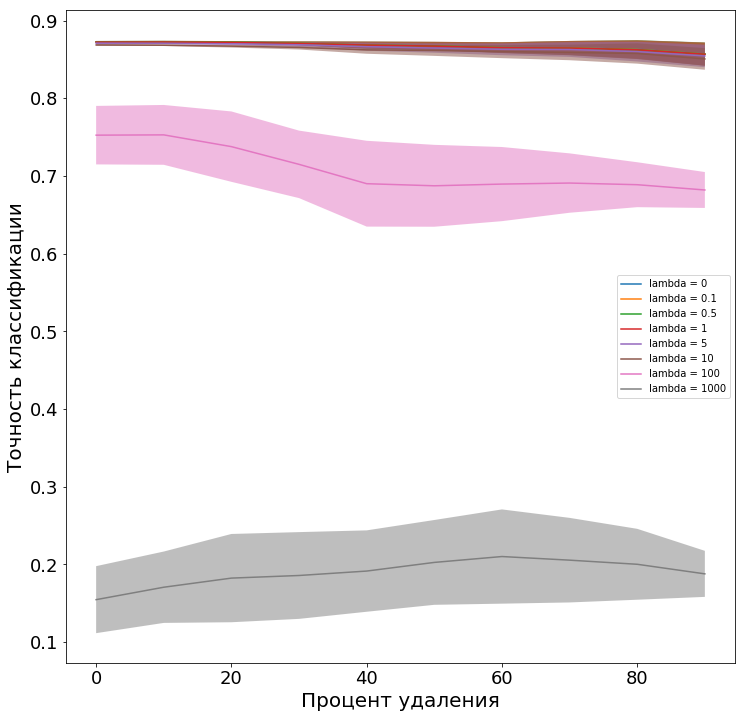

In [92]:
loss_fn_nets =[]
nets = []
optimizer_nets = []
mu_glob = []
sigma_glob = []
prune_coef_glob = []
init_nets_output =  init_nets(loss_fn_nets)
train_nets(init_nets_output[0], init_nets_output[1], init_nets_output[2], init_nets_output[3], init_nets_output[4], None)
old_nets = nets[:]

for k,lam in enumerate(lamb):
    for i, net in enumerate(nets):
        new_net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
        for j in range(0, 2): # бежим по слоям
            lam_param = lam / 100
            new_net[j].mean.data*=0
            new_net[j].mean.data+=old_nets[i][j].mean(lam_param)
            new_net[j].mean_b.data*=0
            new_net[j].mean_b.data+=old_nets[i][j].mean_b(lam_param)
            new_net[j].log_sigma.data*=0
            new_net[j].log_sigma.data+=old_nets[i][j].log_sigma(lam_param)
            new_net[j].log_sigma_b.data*=0
            new_net[j].log_sigma_b.data+=old_nets[i][j].log_sigma_b(lam_param)
            
        nets[i] = new_net        
    acc_delete.append(None)
    init_coeff(prune_coef_glob, mu_glob, sigma_glob)
    acc_delete[k]= delete_10(acc_delete[k], prune_coef_glob, mu_glob, sigma_glob, nets, init_nets_output[0])

    
init_coeff(prune_coef_glob, mu_glob, sigma_glob)    
#graph_loss_func()
graph(acc_delete,lamb)
save(acc_delete)


Number of net: 0 tensor(5092563., device='cuda:0') tensor(5092563., device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(5099415., device='cuda:0') tensor(5099415., device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(4811673.5000, device='cuda:0') tensor(4811673.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(4039685.7500, device='cuda:0') tensor(4039685.7500, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(5035912., device='cuda:0') tensor(5035912., device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(4824247.5000, device='cuda:0') tensor(4824247.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(5357531., device='cuda:0') tensor(5357531., device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(4537746.5000, device='cuda:0') tensor(4537746.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(5272149.5000, device='cu

Number of net: 2 tensor(4.7085e+08, device='cuda:0') tensor(4487912.5000, device='cuda:0') tensor(4.6636e+08, device='cuda:0') 0.1
end of epoch:  0
Number of net: 0
Number of net: 1
Number of net: 2
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.18786666666666665
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.18786666666666665
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.18786666666666665
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.18786666666666665
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, dev

Number of net: 1 tensor(1.9184e+08, device='cuda:0') tensor(5091843., device='cuda:0') tensor(1.8675e+08, device='cuda:0') 1
Number of net: 1 tensor(1.9278e+08, device='cuda:0') tensor(6028512.5000, device='cuda:0') tensor(1.8675e+08, device='cuda:0') 1
Number of net: 1 tensor(1.9184e+08, device='cuda:0') tensor(5088968.5000, device='cuda:0') tensor(1.8675e+08, device='cuda:0') 1
Number of net: 1 tensor(1.9097e+08, device='cuda:0') tensor(4224494., device='cuda:0') tensor(1.8675e+08, device='cuda:0') 1
Number of net: 1 tensor(1.9239e+08, device='cuda:0') tensor(5639124., device='cuda:0') tensor(1.8675e+08, device='cuda:0') 1
Number of net: 1 tensor(1.9166e+08, device='cuda:0') tensor(4913538., device='cuda:0') tensor(1.8675e+08, device='cuda:0') 1
Number of net: 1 tensor(1.9218e+08, device='cuda:0') tensor(5431137., device='cuda:0') tensor(1.8675e+08, device='cuda:0') 1
Number of net: 1 tensor(1.9204e+08, device='cuda:0') tensor(5289022.5000, device='cuda:0') tensor(1.8675e+08, device=

0.18786666666666665
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.18786666666666665
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.18786666666666665
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.18786666666666665
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.18786666666666665
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.18786666666666665
Number of net: 0 tensor(1.9506e+11, device='cuda:0') tensor(5092563., device='cuda:0') tensor(1.9505e+11, device='cuda:0') 10
Number of net: 0 te

Number of net: 1 tensor(1.8681e+10, device='cuda:0') tensor(5788500., device='cuda:0') tensor(1.8675e+10, device='cuda:0') 100
Number of net: 2 tensor(4.6637e+11, device='cuda:0') tensor(4527674., device='cuda:0') tensor(4.6636e+11, device='cuda:0') 100
Number of net: 2 tensor(4.6637e+11, device='cuda:0') tensor(5148536., device='cuda:0') tensor(4.6636e+11, device='cuda:0') 100
Number of net: 2 tensor(4.6637e+11, device='cuda:0') tensor(4755757., device='cuda:0') tensor(4.6636e+11, device='cuda:0') 100
Number of net: 2 tensor(4.6637e+11, device='cuda:0') tensor(3681020., device='cuda:0') tensor(4.6636e+11, device='cuda:0') 100
Number of net: 2 tensor(4.6637e+11, device='cuda:0') tensor(4340823., device='cuda:0') tensor(4.6636e+11, device='cuda:0') 100
Number of net: 2 tensor(4.6637e+11, device='cuda:0') tensor(4591179., device='cuda:0') tensor(4.6636e+11, device='cuda:0') 100
Number of net: 2 tensor(4.6637e+11, device='cuda:0') tensor(5135425.5000, device='cuda:0') tensor(4.6636e+11, d

0.18786666666666665


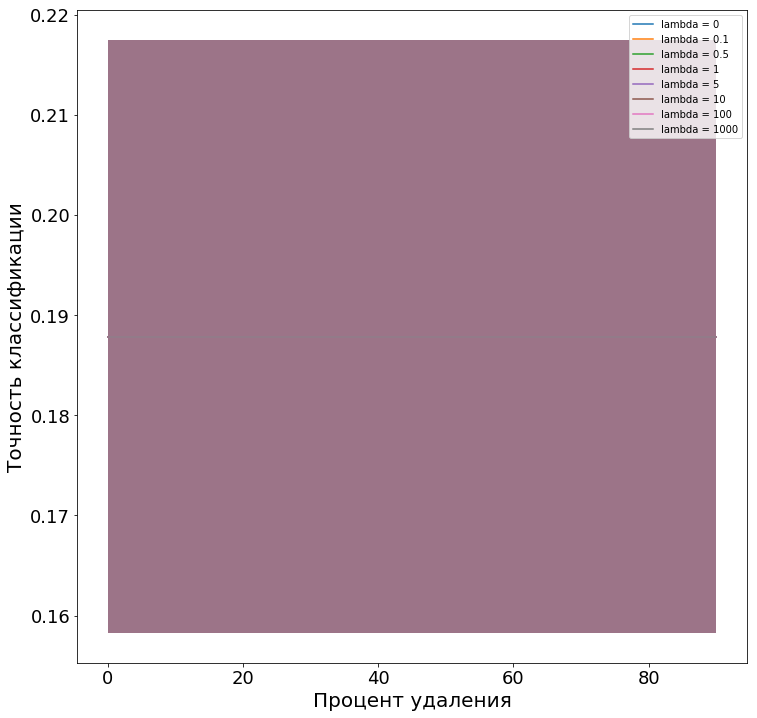

In [98]:
filename = 'linearsn3 + 1'
mode = 'frank'
lambda_sample_num = 1
epoch_num = 1
#old_nets = nets[:]
acc_delete = []

for k,lam in enumerate(lamb):
    nets = old_nets[:]
    mu_glob = []
    sigma_glob = []
    prune_coef_glob = []
    train_nets(init_nets_output[0], init_nets_output[1], init_nets_output[2], init_nets_output[3], init_nets_output[4], lam)
    init_coeff(prune_coef_glob, mu_glob, sigma_glob)   
    acc_delete.append(None)
    acc_delete[k]= delete_10(acc_delete[k], prune_coef_glob, mu_glob, sigma_glob, nets, init_nets_output[0])
graph(acc_delete,lamb)
save(acc_delete)

In [72]:
old_nets

[VarSeqNet(
   (0): VarLayer()
   (1): VarLayer()
 ), VarSeqNet(
   (0): VarLayer()
   (1): VarLayer()
 ), VarSeqNet(
   (0): VarLayer()
   (1): VarLayer()
 )]